# Grad-CAM : Visual Explanations from Deep Networks via Gradient-based Localization.”
-  It consists of taking the output feature map of a convolution layer (typically the penultimate_layer), given an input image, and weighing every channel in that feature map by the gradient of the class
with respect to the channel. 
-  Intuitively, you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,”

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import keras.backend as K

/home/abhijit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
model = keras.applications.VGG16(include_top=True,weights="imagenet")

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
def preprocess_input(img):
    img = img.astype(np.float32)
    img = keras.applications.vgg16.preprocess_input(img)
    return np.expand_dims(img, axis=0)

In [6]:
image = np.array(keras.preprocessing.image.load_img(path="./images/lion_and_tiger.jpg",target_size=(224,224)))

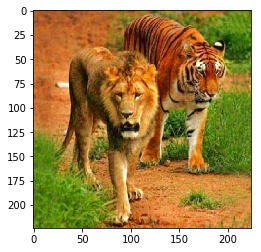

In [7]:
plt.imshow(image)
plt.show()

In [8]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [9]:
preprocessed_image = preprocess_input(image)
predictions = np.squeeze(model.predict(preprocessed_image))
# top5 predictions
top5_indices = np.argsort(predictions)[::-1][:5]
for prediction_index in top5_indices:
    prediction_class = labelmap[str(prediction_index)]
    prediction_score = predictions[prediction_index]
    print("Prediction index: {}".format(prediction_index))
    print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))
    print("#############################################################")

Prediction index: 292
Prediction: tiger
Confidence score: 0.5485735535621643
#############################################################
Prediction index: 291
Prediction: lion
Confidence score: 0.3459724187850952
#############################################################
Prediction index: 282
Prediction: tiger_cat
Confidence score: 0.09866759926080704
#############################################################
Prediction index: 260
Prediction: chow
Confidence score: 0.001544689410366118
#############################################################
Prediction index: 293
Prediction: cheetah
Confidence score: 0.0009051536326296628
#############################################################


In [10]:
class_index = 291  # index to visualize

In [11]:
class_output = model.output[0, class_index]

In [12]:
class_output

<tf.Tensor 'strided_slice:0' shape=() dtype=float32>

In [13]:
last_conv_layer = model.get_layer('block5_conv3')

In [14]:
grads = K.gradients(class_output, last_conv_layer.output)[0]  #returns grad, list of variables

In [15]:
grads

<tf.Tensor 'gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>

In [16]:
pooled_grads = K.mean(grads, axis=(0, 1, 2)) 

In [17]:
pooled_grads  # Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel

<tf.Tensor 'Mean:0' shape=(512,) dtype=float32>

In [18]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([preprocessed_image])
for i in range(512): # number of channels in that layer:
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [19]:
conv_layer_output_value.shape

(14, 14, 512)

In [20]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

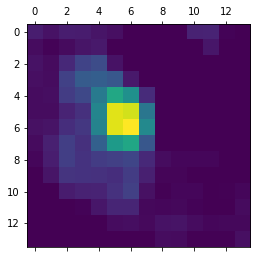

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [22]:
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)  # OpenCV is in BGR

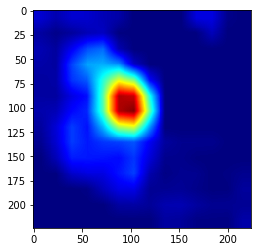

In [23]:
plt.imshow(heatmap)

In [24]:
def overlay(array1, array2, alpha=0.5):
    """Overlays `array1` onto `array2` with `alpha` blending.
    Args:
        array1: The first numpy array.
        array2: The second numpy array.
        alpha: The alpha value of `array1` as overlayed onto `array2`. This value needs to be between [0, 1],
            with 0 being `array2` only to 1 being `array1` only (Default value = 0.5).
    Returns:
        The `array1`, overlayed with `array2` using `alpha` blending.
    """
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [25]:
gradcam_image = overlay(heatmap, image, 0.5)

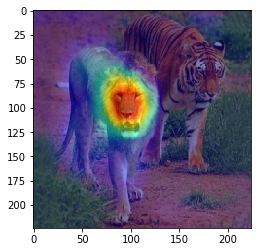

In [26]:
plt.imshow(gradcam_image)